In [1]:
import lancedb
import pyarrow as pa
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
from io import BytesIO
from pyarrow import schema, field, float32, string, utf8
import pandas as pd
import json
from datetime import datetime
from lancedb.pydantic import LanceModel, Vector
import numpy as np
from pydantic import BaseModel
import os


c:\Users\suraj\OneDrive\Desktop\sdp_folder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load all the input data

with open(r"new_train_data.json", 'r') as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)

print(df.head())

                                           image_url           image_path  \
0  https://m.media-amazon.com/images/I/81XKaSKvly...  images/train/0.jpeg   
1  https://m.media-amazon.com/images/I/91dDMDg+QT...  images/train/1.jpeg   
2  https://m.media-amazon.com/images/I/71TJ9p46PV...  images/train/2.jpeg   
3  https://m.media-amazon.com/images/I/81Y+je7CEg...  images/train/3.jpeg   
4  https://m.media-amazon.com/images/I/61B8o9Ulqp...  images/train/4.jpeg   

         brand                                      product_title class_label  \
0    Womanista  Women's Georgette Saree with Blouse Piece (TKI...       saree   
1      Yashika         Women Linen Printed Sarees Free Size (BEE)       saree   
2    Womanista  Organza Floral Print Saree with Blouse Piece(W...       saree   
3  PERFECTBLUE  Women's Digital Cotton Linen Blend Saree with ...       saree   
4   VAIVIDHYAM  Designer Sarees Women's Banarasi Cotton Silk S...       saree   

  color  
0   NaN  
1   NaN  
2   NaN  
3   NaN  


In [4]:
# get the clip model and processor

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

db = lancedb.connect("./my_lancedb_new")

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


In [5]:
# we shall now get the embeddings (vectors) for the train data

###
def get_image_embedding_from_path(image_path):
    img = Image.open(image_path).convert('RGB')
    inputs = processor(images=img, return_tensors="pt")
    outputs = model.get_image_features(**inputs)
    return outputs[0].detach().numpy()

def get_text_embedding(text):
    text_inputs = processor(text=text, return_tensors="pt", truncation=True) #Truncating to fit model length
    text_embedding = model.get_text_features(**text_inputs)
    return text_embedding[0].detach().numpy()

# save the embeddings in a list
embeddings = []
product_title_embeddings = []

for i in range(len(df)):
    if (i%10000==0): print(i)
    image_url = df.iloc[i]['image_path']
    
    # image embedding
    try:
        embedding = get_image_embedding_from_path(image_url)
    except Exception as e:
        print(f"Error processing image {image_url}: {e}")
        embedding = np.zeros(512)  # Placeholder vector if image cannot be processed
    embeddings.append(embedding)
    
    # product_title embedding
    product_title = df.iloc[i]['product_title']
    title_embedding = get_text_embedding(product_title)
    product_title_embeddings.append(title_embedding)

0
10000
20000
30000
40000
50000


The channel dimension is ambiguous. Got image shape (1, 1, 3). Assuming channels are the first dimension.


Error processing image images/train/55852.jpeg: mean must have 1 elements if it is an iterable, got 3
60000


The channel dimension is ambiguous. Got image shape (1, 1, 3). Assuming channels are the first dimension.


Error processing image images/train/68567.jpeg: mean must have 1 elements if it is an iterable, got 3


The channel dimension is ambiguous. Got image shape (1, 1, 3). Assuming channels are the first dimension.


Error processing image images/train/71885.png: mean must have 1 elements if it is an iterable, got 3
70000


The channel dimension is ambiguous. Got image shape (1, 1, 3). Assuming channels are the first dimension.


Error processing image images/train/78873.png: mean must have 1 elements if it is an iterable, got 3
80000


In [6]:
print(len(embeddings))
print(len(product_title_embeddings))

85966
85966


In [7]:
# creating a dataframe
df['Image_Embeddings'] = embeddings
df['Product_Title_Embeddings'] = product_title_embeddings

In [8]:
import numpy as np
from PIL import Image
from pydantic import BaseModel
from lancedb.pydantic import LanceModel, Vector
import pandas as pd

uri = "data/sample-lancedb-nested"

class Metadata(BaseModel):
    image_path: str
    brand: str
    product_title: str
    class_label: str
    color: str

class Document(BaseModel):
    image_url: str
    meta: Metadata

class LanceSchema(LanceModel):
    id: str
    vector: Vector(512)
    payload: Document

data = []
for index, row in df.iterrows():
    try:
        # Ensure that the embeddings are numpy arrays
        image_embeddings = np.array(row['Image_Embeddings'])
        title_embeddings = np.array(row['Product_Title_Embeddings'])

        # Check the shape of the embeddings
        if image_embeddings.shape[0] != 512 or title_embeddings.shape[0] != 512:
            raise ValueError(f"Embeddings must be of size 512. Got: "
                             f"Image: {image_embeddings.shape[0]}, Title: {title_embeddings.shape[0]}")
        
        # Use image embeddings and title embeddings
        combined_vector = image_embeddings + title_embeddings

        data.append(LanceSchema(
            id=f"id{index}",
            vector=combined_vector,  # Ensure this matches your model definition
            payload=Document(
                image_url=row['image_url'],
                meta=Metadata(
                    image_path=row['image_path'],
                    brand=row['brand'],
                    product_title=row['product_title'],
                    class_label=row['class_label'],
                    color=str(row.get('color', ''))
                )
            ),
        ))
        
    except Exception as e:
        print(f"Error processing row {index}: {e}")

table_name = "my_table"
tbl = db.create_table(table_name, data=data, mode='overwrite')  # Create and save the table
print(f"Table '{table_name}' created and saved.")

def load_table():
    return db.open_table(table_name)


Table 'my_table' created and saved.


In [8]:
def embedding_from_text(query):
    text_inputs = processor(text=query, return_tensors="pt", truncation=True)
    query_vector = model.get_text_features(**text_inputs)
    return query_vector[0].detach().numpy()

def embedding_from_image(image_path):
    img = Image.open(image_path).convert('RGB')
    inputs = processor(images=img, return_tensors="pt")
    image_vector = model.get_image_features(**inputs)
    return image_vector[0].detach().numpy()

def search_lancedb(query_vector):
    tbl = load_table()
    results = tbl.search(query_vector).metric('cosine').nprobes(10).limit(10).to_df()
    return results

C:\Users\suraj\AppData\Local\Temp\ipykernel_22580\2601911138.py:14: UnsupportedWarning: to_df is unsupported as of 0.4.0. Use to_pandas() instead
  results = tbl.search(query_vector).metric('cosine').nprobes(10).limit(10).to_df()


Search results for text query:
Product Title: Green Banarasi Silk Saree With Blouse Peice
Image Path: images/train/6838.jpeg



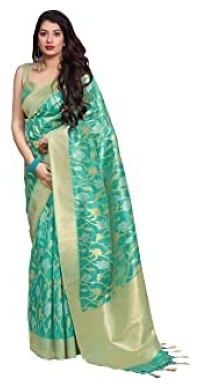

Product Title: FASHION SILK SAREE (GREEN)
Image Path: images/train/4128.jpeg



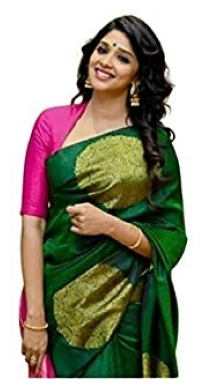

Product Title: Silk Saree with Blouse Piece (GREEN-BANDAN_Green_Free Size)
Image Path: images/train/5115.jpeg



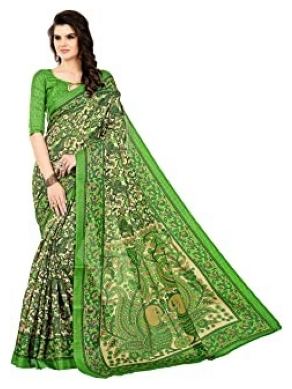

Product Title: Embroidered Fashion Pure Silk Saree Light Green Color
Image Path: images/train/8200.jpeg



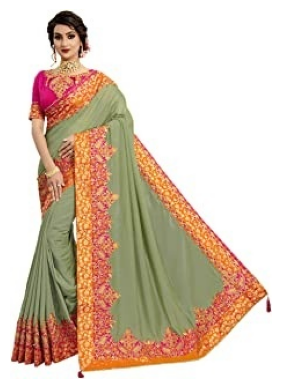

Product Title: Banarasi Style Chiffon saree Color: Green
Image Path: images/train/5285.jpeg



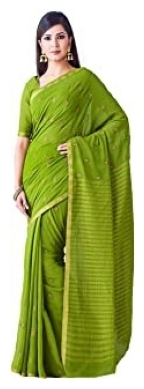

Product Title: Women's Green Silk Saree With Blouse
Image Path: images/train/2160.jpeg



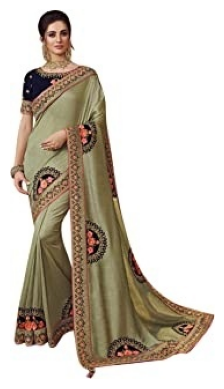

Product Title: Synthetic with Blouse Piece Saree (Pastry Green_AP Free)
Image Path: images/train/8432.jpeg



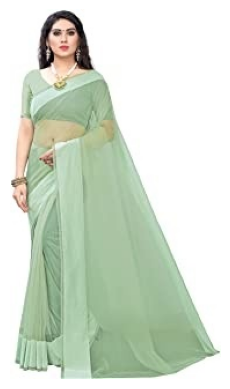

Product Title: MEHANDI GREEN SATIN CHANDERI SILK SAREE FOR INDIAN WOMEN
Image Path: images/train/3897.jpeg



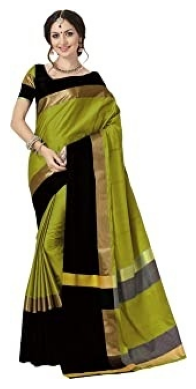

Product Title: Kanjivaram Style Art Silk Saree Color : Green
Image Path: images/train/8464.jpeg



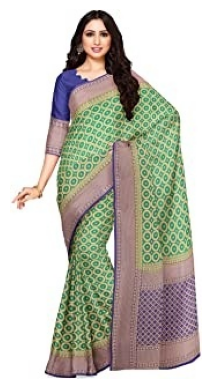

Product Title: Women's Silk Saree With Blouse Piece (A44 GREEN _Green)
Image Path: images/train/2888.jpeg



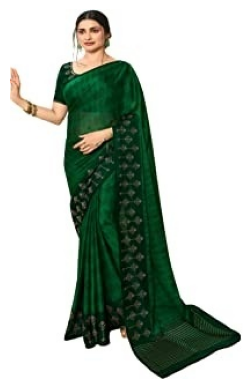

In [9]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# example 1: Text Search
text_query = "Light Green Silk Saree"
text_query_vector = embedding_from_text(text_query)
search_results = search_lancedb(text_query_vector)  # Use the updated search function

print("Search results for text query:")
for index, row in search_results.iterrows():
    print(f"Product Title: {row['payload']['meta']['product_title']}")
    image_path = row['payload']['meta']['image_path']
    print(f"Image Path: {image_path}\n")
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Search results for image query:
Product Title: Men Navy Blue &amp; Orange Printed Sherwani Set
Image Path: images/train/77791.jpg



C:\Users\suraj\AppData\Local\Temp\ipykernel_22580\2601911138.py:14: UnsupportedWarning: to_df is unsupported as of 0.4.0. Use to_pandas() instead
  results = tbl.search(query_vector).metric('cosine').nprobes(10).limit(10).to_df()


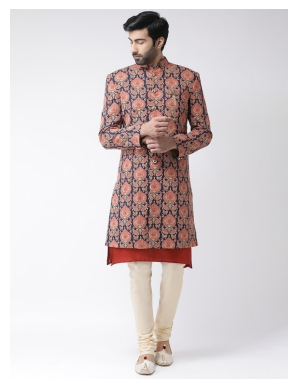

Product Title: Hand Embroidered Art Silk Sherwani in Orange
Image Path: images/train/79029.jpg



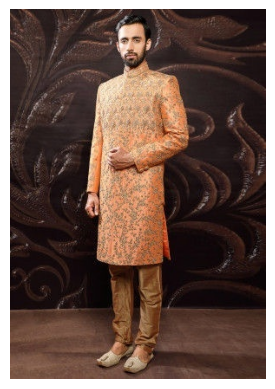

Product Title: Men Cream &amp; Peach Self Design Kurta with Pyjamas &amp; Nehru Jacket
Image Path: images/train/42626.jpeg



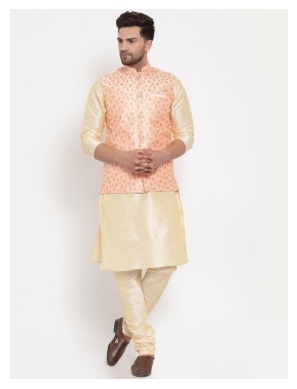

Product Title: Men Orange &amp; Blue Printed Sherwani Set
Image Path: images/train/77652.jpg



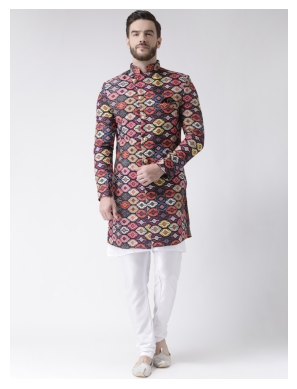

Product Title: Men Navy Blue &amp; Red Printed Sherwani Set
Image Path: images/train/77888.jpg



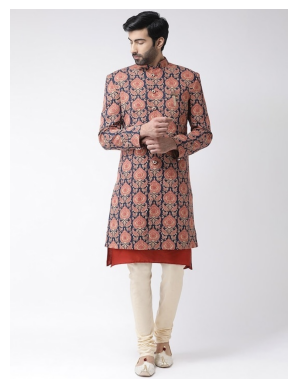

Product Title: Men Grey Embroidered Jacquard Sherwani with  Kurta &amp; Pyjama Pants
Image Path: images/train/77800.jpg



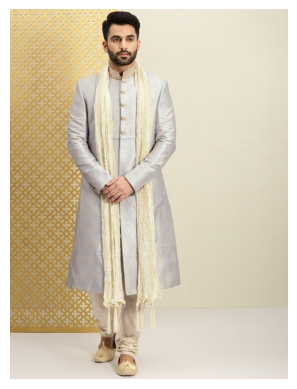

Product Title: Men Gold-Toned &amp; Cream-Coloured Printed Kurta with Churidar
Image Path: images/train/41572.jpeg



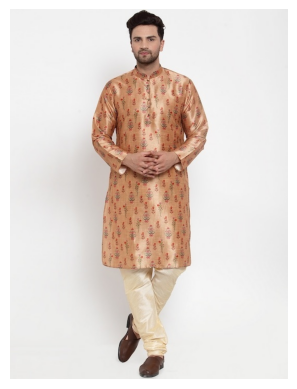

Product Title: Men Orange &amp; Brown Printed Sherwani Set
Image Path: images/train/77691.jpg



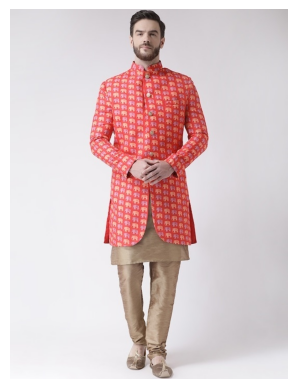

Product Title: Men Multicoloured Printed Sherwani With White Solid Dhoti Pants
Image Path: images/train/77738.jpg



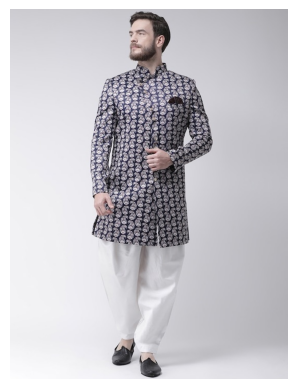

Product Title: Men Orange &amp; White Solid Kurta with Churidar
Image Path: images/train/42260.jpeg



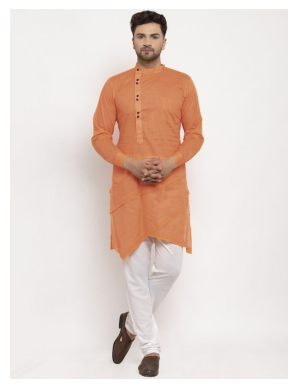

In [10]:
# Example 2: Image search
image_query_path = r"C:\Users\suraj\Downloads\test_img3.jpeg"
image_vector = embedding_from_image(image_query_path)
image_search_results = search_lancedb(image_vector)  # Use the updated search function

print("Search results for image query:")
for index, row in image_search_results.iterrows():
    print(f"Product Title: {row['payload']['meta']['product_title']}")
    image_path = row['payload']['meta']['image_path']
    print(f"Image Path: {image_path}\n")
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()